# Analytic Deep Prior

The so called deep image prior (DIP) has been recently introduced as a machine learning approach for some tasks in image processing (Ulyanov et al. 2017). 

Usually, such machine learning approaches utilize large sets of training data, hence, it was somewhat surprising that deep image priors are based on a single data point $y^\delta$.

In order to solve the inverse problem $Ax=y^\delta$, the task of DIP is to train a network $\varphi_\Theta(z)$ with parameters $\Theta$ by minimizing the simple loss function $\| A \varphi_\Theta(z) - y^\delta \|^2$. The minimization is with respect to $\Theta,$ the input  $z$ is kept fixed. After training, the solution of the problem is approximated by $\hat x = \varphi_\Theta(z).$

For the analytical deep prior we consider the particular architecture of a fully connected feedforward iterative network with $L$ identical layers.


## Definition 
Consider a fully connected neural network $\varphi_\Theta$ with $L$  layers, whose activation function is a proximal mapping $\mathrm{prox}_{\alpha \lambda R}$ with respect to a convex functional $R:X \rightarrow I\!\!R$, i.e

$\varphi_\Theta(z) = x^L,$
    
where

$x^{k+1} =\mathrm{prox}_{\alpha \lambda R} (Wx^k + b)$

and $x_0 = z.$ Further assume that $W$ can be decomposed as $W=I-B^*B$ with a bounded operator $B:X \rightarrow W$ and that the bias satisfies $b= \lambda B^*y^\delta$. Then the output of the network is the $L$-iterative of the Proximal Gradient (PG) method for minimizing the Tikhonov functional

$J_B(x)= \frac{1}{2} \| B x - y^\delta\|^2  + \alpha R(x).$ 

Assume that a unique minimizer $x(B) = \mathrm{argmin\ } J_B(x)$ exists. We call this setting an **analytic deep prior** if $W$, resp. $B$, is trained from a single data point $y^\delta$ by gradient descent applied to \begin{equation}
    \min_B\|Ax(B) - y^\delta\|^2.
\end{equation}



## Implementation

In order to guarantee that the output of the network $x(B)$ actually converges to $\mathrm{argmin\ } J_B$, the network should in principle have thousands of layers, because of the slow convergence of the PG method. 

This is prohibitive from the implementation point of view. During the training iterations, in which we update $B$, we therefore consider only a reduced network with a small number, $L=10,$ of layers but we set the input to be the network's output after the previous iteration. This is equivalent to adding $L$ new identical layers, with ${W_k = I- \lambda B_k^TB_k}$ and ${b_k=\lambda B_k^T y^\delta}$, at the end of an implicit network which is growing by $L$ layers at a time. After the $k$-th iteration, we have implicitly created a network that has $(k+1)L$ layers. However, in the next iteration $B$ is updated considering only back-propagation over the last $L$ layers.

![title](network.png)

In the figure $\Theta_k$ refers to $(W_k, b_k)$

In [1]:
import tensorflow as tf
import warnings
import numpy as np
from scipy.ndimage import gaussian_filter

warnings.filterwarnings("ignore")


def peak(s):
    return np.mean(np.abs(s)**2)


def snr(s1, s2):
    p1 = peak(s1)
    p2 = peak(s2)
    return 10 * np.log10((p1-p2)/p2)


def penalty(x):
    return np.sum(np.square(x))
    
    
class Callback:
    def __init__(self, x_true=None):
        self.x_true = x_true
        self.x_seq = []
        self.true_err_seq = []
        self.B_seq = []

    def __call__(self, *args, **kwargs):
        if self.x_true is not None and 'x' in kwargs:
            self.true_err_seq += [penalty(self.x_true - kwargs['x'].reshape(-1))]
        if 'x' in kwargs:
            self.x_seq += [kwargs['x']]
        if 'B' in kwargs:
            self.B_seq += [kwargs['B']]


def tikhonov_l2(A, y_delta, alpha):
    W = np.matmul(np.transpose(A), A) + alpha * np.eye(A.shape[0])
    b = np.matmul(np.transpose(A), y_delta)
    return np.linalg.solve(W,b)


def analytic_deep_prior_l2(A, z, y_delta, alpha, lam=1.0, pen='l2', iters=20000, layers=10, lr=0.01, callback=None, 
                           callback_interval=1, verbose=1):
    z = z.reshape(-1,1)
    x_shape = z.shape
    n = x_shape[0]

    y_tensor = tf.constant(y_delta.reshape(-1,1), dtype=tf.float64)

    A_tensor = tf.constant(A, dtype=tf.float64)
    B_tensor = tf.Variable(A, dtype=tf.float64)
    
    alpha_tensor = tf.constant(alpha, dtype=tf.float64)
    lambda_tensor = tf.constant(lam, dtype=tf.float64)

    z_holder = tf.placeholder(tf.float64, shape=x_shape)

    W = tf.eye(n, dtype=tf.float64) - lambda_tensor * tf.matmul(tf.transpose(B_tensor), B_tensor)
    b = lambda_tensor * tf.matmul(tf.transpose(B_tensor), y_tensor)

    
    def prox(x):
        eps = alpha_tensor * lambda_tensor
        return x / (1 + eps)

    x_tensor = z_holder

    for i in range(layers):
        x_tensor = tf.matmul(W, x_tensor) + b
        x_tensor = prox(x_tensor)

    residual_tensor = tf.reduce_sum(tf.square(y_tensor - tf.matmul(A_tensor, x_tensor)))
    opt = tf.train.GradientDescentOptimizer(lr).minimize(residual_tensor)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    x = None
    x_prev = None
    for i in range(iters):
        x, res, lam, alpha, B = sess.run([x_tensor, residual_tensor, lambda_tensor, alpha_tensor, B_tensor],
                                         {z_holder: z})
        sess.run([opt], {z_holder: z})
        
        if verbose and i % callback_interval == 0:
            print('iter={}, residual={}     '.format(i, res), end="\r")
            if callback is not None:
                callback(x=x, res=res, pen=penalty(x), lam=lam, alpha=alpha, B=B)
        z = x
        
    sess.close()
    return x

## Plot methods

In [2]:
from matplotlib import gridspec


def plot_data(ax, pts, y_true, y_delta):
    ax.plot(pts, y_true, label=r'$y^\dagger$', linestyle='--')
    ax.plot(pts, y_delta, label=r'$y^\delta$',alpha=0.8)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def plot_true_solution(ax, pts, x_true):
    ax.plot(pts, x_true, label=r'$x^\dagger$', linestyle=':', color='black')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def plot_true_error(ax, true_err, ref_err=None):
    ax.set_title('True error')
    ax.plot(true_err, color='tab:blue')
    ax.axhline(ref_err, 0, len(true_err), color='tab:orange', linestyle='--')
    ax.set_xticks([0, len(true_err)])
    ax.set_xticklabels([0, len(true_err)])
    ax.set_yscale('log')


def plot_matrix(ax, matrix, label=''):
    im = ax.imshow(matrix, cmap='jet')
    ax.set_title(label)
    ax.set_axis_off()
    plt.colorbar(im, ax=ax, use_gridspec=True)


def plot_matrix_convergence(ax, A, B_seq):
    ax.set_title(r'$\Vert B_{k}-B_{k-1} \Vert_F^2$')
    seq = [np.linalg.norm(B_seq[i] - B_seq[i-1], 'fro')**2 for i in range(1, len(B_seq))]
    ax.plot(range(1, len(B_seq)), seq, color='tab:red')
    ax.set_xticks([0, len(B_seq)])
    ax.set_xticklabels([0, len(B_seq)])
    ax.set_yscale('log')


def plot_reconstructions(ax, pts, x_true, x_ref, x_deep):
    ax.plot(pts, x_true, label='$x^\dagger$', linestyle=':', color='black')
    ax.plot(pts, x_ref, color='tab:orange', label='$x(A)$', linestyle='--', alpha=0.7)
    ax.plot(pts, x_deep, label='$x(B_{opt})$', color='tab:blue', alpha=0.7)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def plot_summary_fixed_alpha(pts, A, alpha, x_true, x_ref, B_seq, x_seq):
    fig = plt.figure(figsize=(11, 2.2))
    axes = []
    gs1 = gridspec.GridSpec(1, 1)
    axes += [fig.add_subplot(gs1[0])]
    gs2 = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    axes += [fig.add_subplot(gs2[0])]
    axes += [fig.add_subplot(gs2[1])]
    gs3 = gridspec.GridSpec(1, 1)
    axes += [fig.add_subplot(gs3[0])]
    
    true_err = list([penalty(x_true - x_seq[i].reshape(-1)) for i in range(len(x_seq))])

    axes[0].set_title(r'Reconstructions ($\alpha={}$)'.format(alpha))

    plot_reconstructions(axes[0], pts, x_true, x_ref, x_seq[-1])
    plot_true_error(axes[1], true_err, ref_err=penalty(x_true - x_ref))
    plot_matrix_convergence(axes[2], A, B_seq)
    plot_matrix(axes[3], B_seq[-1], label=r'$B_{opt}$')

    gs1.tight_layout(fig, rect=[0, 0, 0.46, 0.99])
    gs2.tight_layout(fig, rect=[0.45, 0, 0.79, 1], w_pad=1.0)
    gs3.tight_layout(fig, rect=[0.65, 0, 1.0, 1.00])

## Numerical Example (l2 regularization)
We now use the analytic deep prior approach for solving an inverse problem with the following integration operator $A:L^2\left(\left[0,1\right]\right)\rightarrow L^2\left(\left[0,1\right]\right)$
\begin{equation}
\label{integration_operator}
\left(Ax\right)(t) = \int_0^{t}x(s) ds.
\end{equation}
$A$ is linear and compact, hence  the inverse problem is ill-posed. Discretizing $A$ yields the matrix:

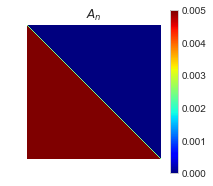

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

n=200
h = 1 / n
A = h * (np.tril(np.ones(n)) - (1 / 2) * np.diag(np.ones(n)))
L = np.linalg.norm(A, 2) ** 2

pts = np.arange(h / 2, 1, h)
u, s, v = np.linalg.svd(A)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)
plot_matrix(ax, A, '$A_n$')

plt.savefig('figures/operator_matrix.pdf')

We aim to recover $x^\dagger$ from $y^\delta$ considering the setting established in Def. 3.1 from the paper, for ${R(\cdot)=\frac{1}{2}\|\cdot\|^2}$ and a fixed value of $\alpha$. That means the solution $x$ is parametrized by the weight matrix $B$ of the network, i.e. $x(B) = \varphi_W(z)$ with $W = I-B^TB$ and $z \in \mathbb{R}^n$ some arbitrary fixed input. 

Solving the inverse problem is now equivalent to training the network $\varphi_W(z)$, i.e. finding optimal $B$, to minimize the loss function $\| A \varphi_W(z) - y^\delta \|^2$ for the single data point $(z, y^\delta)$. 

Afterwards, the reconstruction is obtained by computing $x(B)=\mathrm{argmin\ } J_B$.

In order to properly update $B$ by back-propagation, the network was implemented ensuring that the output $x(B)$ actually converges to $\mathrm{argmin\ } J_B$.

In [4]:
def fixed_alpha_l2(alpha, lr, iters):
    z = np.random.normal(0, 0.1, size=x_true.shape)
    print('alpha={}, lr={}, iter={}'.format(alpha, lr, iters))
    
    callback = Callback(x_true=x_true)
    x_deep = analytic_deep_prior_l2(A, z=z, y_delta=y_delta, alpha=alpha, lam=1/L, iters=iters, lr=lr, callback=callback)
    x_tik = tikhonov_l2(A, y_delta, alpha)

    print('standard tikhonov error: {}'.format(penalty(x_tik - x_true)))
    print('analytic deep prior error: {}'.format(penalty(x_deep.reshape(-1) - x_true)))
    
    plot_summary_fixed_alpha(pts, A, x_true=x_true, x_seq=callback.x_seq, x_ref=x_tik, B_seq=callback.B_seq, alpha=alpha)

### Example 1
We choose $x^\dagger \in \mathbb{R}^n$ to be one of its singular vectors $u$. Then we set the noisy data ${y^\delta = A_n x^\dagger + \tau}$ with ${\tau \sim \mathcal{N}(0,\sigma^2\mathbb{1}_n)}$ and $\sigma$ equals $10\%$ of the largest coefficient of $y^\dagger$. 



SNR: 16.968842047620846


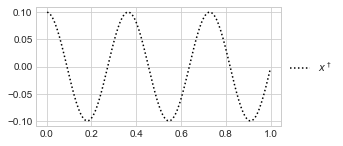

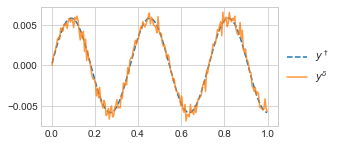

In [5]:
x_true = v[5]

fig = plt.figure(figsize=(5.5, 2.2))
ax = fig.add_subplot(1, 1, 1)
plot_true_solution(ax, pts, x_true)
plt.savefig('figures/x_true_l2.pdf')

y_true = np.dot(A, x_true)
delta = 0.1 * np.max(np.abs(y_true))
y_delta = y_true + np.random.normal(0, delta, size=y_true.shape)

print('SNR: {}'.format(snr(y_delta, y_delta-y_true)))

fig = plt.figure(figsize=(5.3, 2.2))
ax = fig.add_subplot(1, 1, 1)
plot_data(ax, pts, y_true, y_delta)
plt.savefig('figures/y_delta_l2.pdf')

alpha=0.0015, lr=0.01, iter=3000
Instructions for updating:
Colocations handled automatically by placer.
standard tikhonov error: 0.09583617691790622   
analytic deep prior error: 0.06235335843655332
alpha=0.0011, lr=0.01, iter=3000
standard tikhonov error: 0.061990169071655325  
analytic deep prior error: 0.020672416989021787


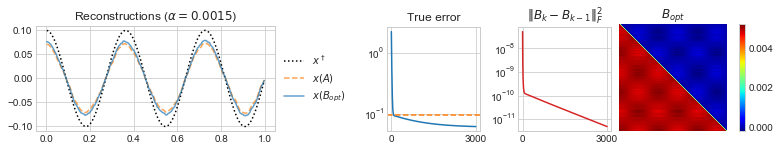

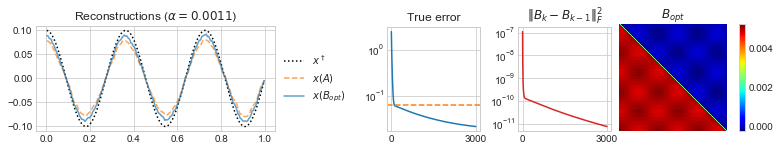

In [6]:
fixed_alpha_l2(alpha=0.0015, lr=0.01, iters=3000)
plt.savefig('figures/fixed_alpha_l2_1.pdf')

fixed_alpha_l2(alpha=0.0011, lr=0.01, iters=3000)
plt.savefig('figures/fixed_alpha_l2_2.pdf')

## Example 2
In this example we consider a more general $y^\delta$.

SNR: 18.321973792956342


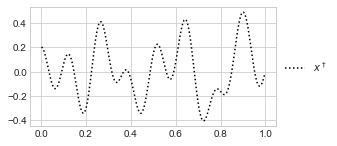

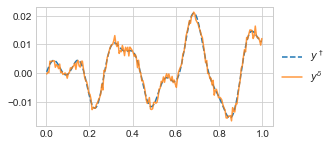

In [7]:
x_true = (-v[5] +2*v[6] + 2*v[15] + np.exp(v[10])-1)

fig = plt.figure(figsize=(5.5, 2.2))
ax = fig.add_subplot(1, 1, 1)
plot_true_solution(ax, pts, x_true)
plt.savefig('figures/extra_x_true_l2.pdf')


y_true = np.dot(A, x_true)
delta = 0.05 * np.max(np.abs(y_true))
y_delta = y_true + np.random.normal(0, delta, size=y_true.shape)

print('SNR: {}'.format(snr(y_delta, y_delta-y_true)))

fig = plt.figure(figsize=(5.3, 2.2))
ax = fig.add_subplot(1, 1, 1)
plot_data(ax, pts, y_true, y_delta)
plt.savefig('figures/extra_y_delta_l2.pdf')

alpha=0.001, lr=0.1, iter=2000
standard tikhonov error: 2.7120481497611633   
analytic deep prior error: 2.040964473829293
alpha=0.0005, lr=0.1, iter=2000
standard tikhonov error: 1.5098033926822765    
analytic deep prior error: 0.3874948642680063


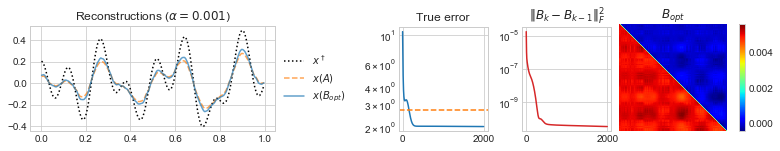

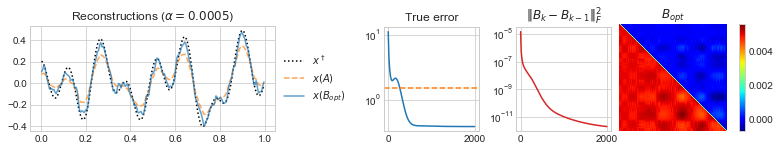

In [8]:
fixed_alpha_l2(alpha=1.0e-3, lr=0.1, iters=2000)
plt.savefig('figures/extra_fixed_alpha_l2_1.pdf')


fixed_alpha_l2(alpha=5.0e-4, lr=0.1, iters=2000)
plt.savefig('figures/extra_fixed_alpha_l2_2.pdf')